# Аналитика продаж для сети видеопроката

---

## Цель исследования:

Проанализировать продажи для сети видеопроката:
- [Провести предобработку данных](#clean);
- [Провести исследовательский анализ данных](#eda);
- [Сформулировать и проверить статистические гипотезы](#test):
  - *Гипотеза различия количества аренд для дней недели понедельник и среда*;
  - *Гипотеза различия общей выручки клиентов сегментов High value и Medium value*;

## Входные данные:

Входные данные представляют собой **4 датасета** (файлы *customer_ltv.csv*, *rental_activity_by_weekday_and_hour.csv*, *revenue_by_category.csv*, *revenue_by_genre_per_month.csv*), содержащие агрегированные данные о выручке по жанрам и категориям, активности аренды по времени, а также LTV клиентов, подготовленные на основе транзакций видеопроката.

### Описание столбцов в используемых датасетах

### **`revenue_by_genre_per_month`**
Отражает помесячную выручку по жанрам фильмов.

| Столбец | Описание |
|--------|----------|
| **month** | Месяц, за который агрегирована выручка. |
| **category** | Жанр фильма (Action, Comedy и др.). |
| **monthly_revenue** | Суммарная выручка за данный жанр в указанном месяце. |
| **payment_count** | Количество платежей, связанных с фильмами данного жанра в этом месяце. |


### **`rental_activity_by_weekday_and_hour`**
Отражает активность аренды по дням недели и часам.

| Столбец | Описание |
|--------|----------|
| **weekday** | День недели. |
| **hour** | Часы суток. |
| **rental_count** | Количество аренд, совершённых в указанный день недели и час. |


### **`revenue_by_category`**
Показывает, какую выручку приносят фильмы каждой категории.

| Столбец | Описание |
|--------|----------|
| **category** | Категория фильма. |
| **revenue** | Общая выручка, полученная от аренды фильмов данной категории. |


### **`customer_ltv`**
Содержит информацию о клиентах и рассчитанные метрики их "Lifetime Value".

| Столбец | Описание |
|--------|----------|
| **customer_id** | Уникальный идентификатор клиента. |
| **first_name** | Имя клиента. |
| **last_name** | Фамилия клиента. |
| **email** | Электронная почта клиента. |
| **active** | Флаг активности клиента (1 — активен, 0 — неактивен). |
| **create_date** | Дата регистрации клиента в системе. |
| **rental_count** | Количество аренд, совершённых клиентом за всё время. |
| **first_rental_date** | Дата первой аренды клиента. |
| **last_rental_date** | Дата последней аренды клиента. |
| **total_revenue** | Общая сумма платежей клиента. |
| **payment_count** | Количество платежей, совершённых клиентом. |
| **avg_payment_count** | Среднее количество платежей в месяце. |
| **ltv_segment** | Сегмент LTV (High, Medium или Low). |


### Предобработка данных <a id="clean"></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import norm, shapiro
from scipy.stats import mannwhitneyu, rankdata

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
sns.set(style="whitegrid", palette="muted")

In [20]:
def load_csv(path):
    return pd.read_csv(path)

def convert_date_columns(df, *args):
    df = df.copy()
    for col in args:
        try:
            df[col] = pd.to_datetime(df[col])
        except:
            pass
    return df

In [21]:
datasets = {
    "revenue_by_genre_per_month": "./csv/revenue_by_genre_per_month.csv",
    "rental_activity_by_weekday_and_hour": "./csv/rental_activity_by_weekday_and_hour.csv",
    "revenue_by_category": "./csv/revenue_by_category.csv",
    "customer_ltv": "./csv/customer_ltv.csv"
}

dfs = {}
for name, path in datasets.items():
    try:
        df = pd.read_csv(path)
        dfs[name] = df
        print(f"Загружено: {name:35s}")
    except FileNotFoundError:
        print(f"Файл не найден: {path}")

Загружено: revenue_by_genre_per_month         
Загружено: rental_activity_by_weekday_and_hour
Загружено: revenue_by_category                
Загружено: customer_ltv                       


In [22]:
dfs["revenue_by_genre_per_month"] = convert_date_columns(dfs["revenue_by_genre_per_month"], 'month')
dfs["customer_ltv"] = convert_date_columns(dfs["customer_ltv"], 'create_date', 'first_rental_date', 'last_rental_date')

In [23]:
weekday_map = {0: "Sunday", 1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday"}
dfs["rental_activity_by_weekday_and_hour"]["weekday"] = dfs["rental_activity_by_weekday_and_hour"]["weekday"].map(weekday_map)

cols = {
    "revenue_by_genre_per_month": "category",
    "rental_activity_by_weekday_and_hour": "weekday",
    "revenue_by_category": "category",
    "customer_ltv": "ltv_segment",
}

def convert_to_category(dfs, config):
    for dataset, col in config.items():
        dfs[dataset][col] = dfs[dataset][col].astype("category")

convert_to_category(dfs, cols)

In [24]:
for key in dfs.keys():
    dfs[key].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype                    
---  ------           --------------  -----                    
 0   month            112 non-null    datetime64[ns, UTC+03:00]
 1   category         112 non-null    category                 
 2   monthly_revenue  112 non-null    float64                  
 3   payment_count    112 non-null    int64                    
dtypes: category(1), datetime64[ns, UTC+03:00](1), float64(1), int64(1)
memory usage: 3.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   weekday       168 non-null    category
 1   hour          168 non-null    int64   
 2   rental_count  168 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 3.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeI

### Исследовательский анализ данных <a id="eda"></a>

In [25]:
for key in dfs.keys():
    display(dfs[key].describe(include=["int64", "float64"]).T)

,count,mean,std,min,25%,50%,75%,max
monthly_revenue,112.00,601.93,192.06,135.66,556.41,635.12,739.87,893.03
payment_count,112.00,143.29,45.56,32.00,133.00,155.00,170.00,214.00


,count,mean,std,min,25%,50%,75%,max
hour,168.00,11.50,6.94,0.00,5.75,11.50,17.25,23.00
rental_count,168.00,95.50,16.24,67.00,87.00,95.00,101.00,266.00


,count,mean,std,min,25%,50%,75%,max
revenue,16.00,"4,213.53",508.84,"3,417.72","3,705.79","4,276.00","4,434.53","5,314.21"


,count,mean,std,min,25%,50%,75%,max
customer_id,599.00,300.00,173.06,1.00,150.50,300.00,449.50,599.00
active,599.00,0.97,0.16,0.00,1.00,1.00,1.00,1.00
rental_count,599.00,26.78,5.11,12.00,23.00,26.00,30.00,46.00
total_revenue,599.00,112.55,25.37,50.85,94.78,110.73,128.70,221.55
payment_count,599.00,26.79,5.11,12.00,23.00,26.00,30.00,46.00
avg_payment_amount,599.00,4.20,0.46,2.94,3.87,4.20,4.52,5.70


В таблицах выше представлены некоторые описательные статистики для числовых переменных для каждого из 4-х датасетов: кол-во наблюдений, среднее, минимальное, максимальное значения, стандартное отклонение, медиана, нижняя и верхняя квартили. Для всех переменных можно сказать, что распределение близко к симметричному, на что указывает близость средних значений и медиан.

Посмотрим на средние значения признаков в трех группах: *High value*, *Medium value*, *Low value*.

In [26]:
dfs['customer_ltv'].groupby('ltv_segment', observed=True).mean(numeric_only=True).T

ltv_segment,A — High value,B — Medium value,C — Low value
customer_id,296.98,299.67,301.25
active,0.98,0.97,0.98
rental_count,35.76,28.34,22.09
total_revenue,165.19,120.79,86.58
payment_count,35.78,28.35,22.10
avg_payment_amount,4.63,4.29,3.95


**Выводы**:
- У клиентов из сегмента *High value* кол-во аренд выше, чем у клиентов из сегмента *Medium value*, аналогично с *Low value*;
- Общая сумма платежей для сегмента *High value* выше, чем *Medium value*, что в свою очередь выше чем у *Low value*. Для кол-ва платежей ситуация схожая;
- Уровень активности в трех группах почти одинаковый, то есть разница между сегментами **не формируется** за счет активности клиента.

#### Графический анализ

При помощи функций построим столбчатые диаграммы для категориальных признаков и гистограммы распределения для числовых признаков, а так же диаграммы размаха.

In [27]:
def plot_bar(df, x, y, title, figsize=(8, 5), rotation=0):
    plt.figure(figsize=figsize)
    sns.barplot(data=df, x=x, y=y)
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.show()


def plot_line(df, x, y, hue=None, title="", figsize=(8, 5)):
    plt.figure(figsize=figsize)
    sns.lineplot(data=df, x=x, y=y, hue=hue, marker='o')
    plt.title(title)
    if hue:
        plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


def plot_scatter(df, x, y, hue=None, title="", figsize=(8, 5)):
    plt.figure(figsize=figsize)
    sns.scatterplot(data=df, x=x, y=y, hue=hue)
    plt.title(title)
    plt.show()


def plot_heatmap(df, x, y, value, title="", figsize=(8, 5)):
    pivot = df.pivot_table(values=value, index=y, columns=x, observed=True)
    plt.figure(figsize=figsize)
    sns.heatmap(pivot, cmap="YlGnBu")
    plt.title(title)
    plt.show()


def plot_box(df, x, y, title="", figsize=(8, 5)):
    plt.figure(figsize=figsize)
    sns.boxplot(data=df, x=x, y=y)
    plt.title(title)
    plt.show()


def plot_regression(df, x, y, title="", figsize=(8, 5)):
    plt.figure(figsize=figsize)
    sns.scatterplot(data=df, x=x, y=y)

    X = df[[x]].values
    Y = df[y].values
    model = LinearRegression()
    model.fit(X, Y)
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_range)
    
    plt.plot(x_range, y_pred, color='orange', linewidth=2)

    coef = model.coef_[0]
    intercept = model.intercept_
    equation = f"y = {coef:.3f}x + {intercept:.3f}"
    r, p_value = pearsonr(df[x], df[y])
    corr_text = f"Коэффициент корреляции: r = {r:.3f}\np-уровень = {p_value:.3e}"

    plt.text(
        0.05, 0.95,
        f"Уравнение регрессии: {equation}\n{corr_text}",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )
    plt.title(title)
    plt.show()

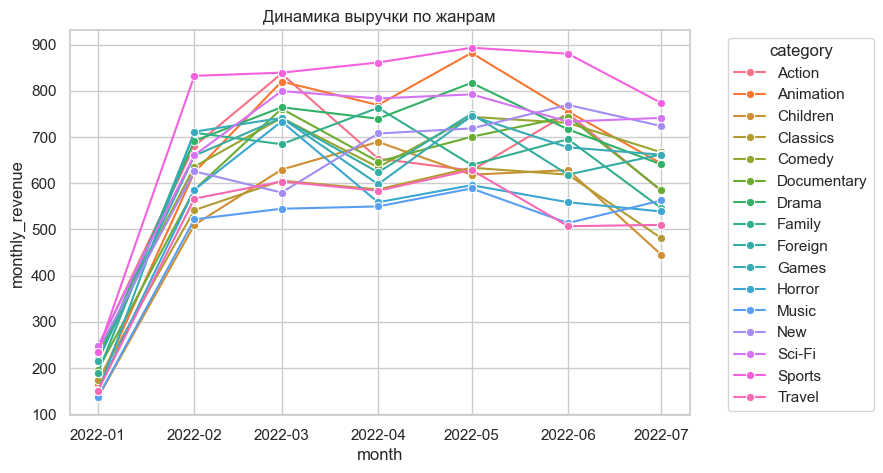

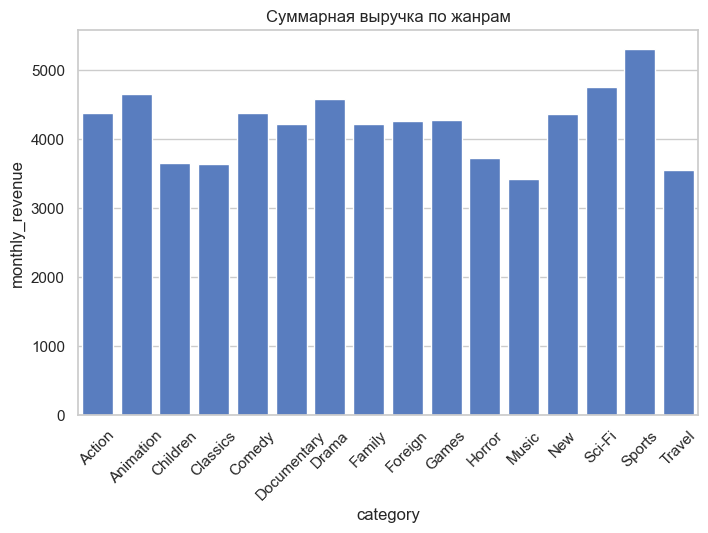

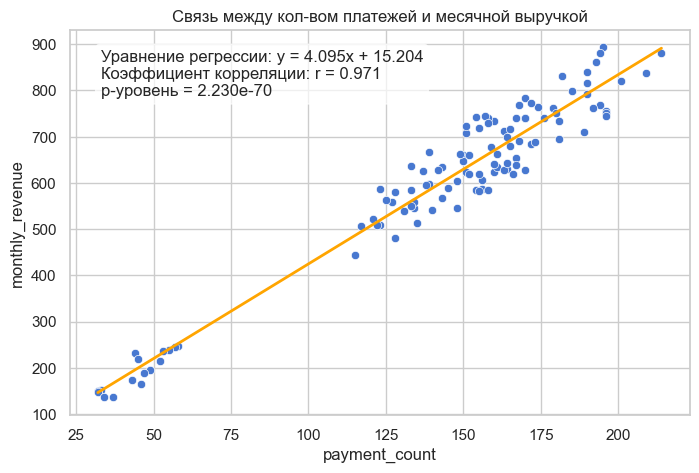

In [28]:
plot_line(
    dfs['revenue_by_genre_per_month'],
    x="month",
    y="monthly_revenue",
    hue="category",
    title="Динамика выручки по жанрам"
)

plot_bar(
    dfs['revenue_by_genre_per_month'].groupby('category', observed=True)['monthly_revenue'].sum().reset_index(),
    x="category",
    y="monthly_revenue",
    title="Суммарная выручка по жанрам",
    rotation=45
)

plot_regression(
    dfs['revenue_by_genre_per_month'],
    x="payment_count",
    y="monthly_revenue",
    title="Связь между кол-вом платежей и месячной выручкой"
)

**Выводы**:
- По первому графику можно заметить более **низкую прибыль** сети видеопроката за **первый месяц** года, в дальнейшем выручка была стабильной;
- Жанр «**Sports**» приносит наибольшую выручку среди всех жанров, на втором и третьем месте идут «*Sci-fi*» и «*Animation*»;
- Третий график демонстрирует **сильную положительную корреляцию** между кол-вом платежей и месячной выручкой, при этом она является статистически значимой.

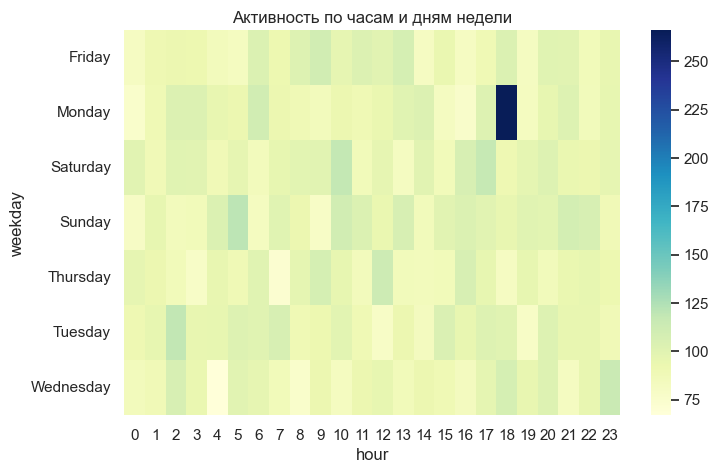

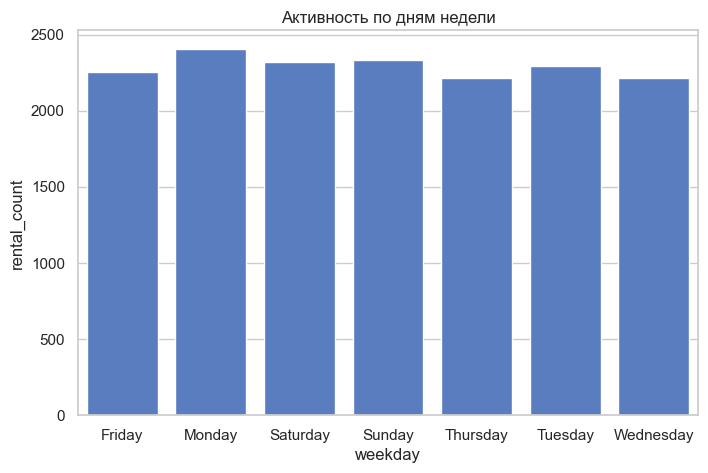

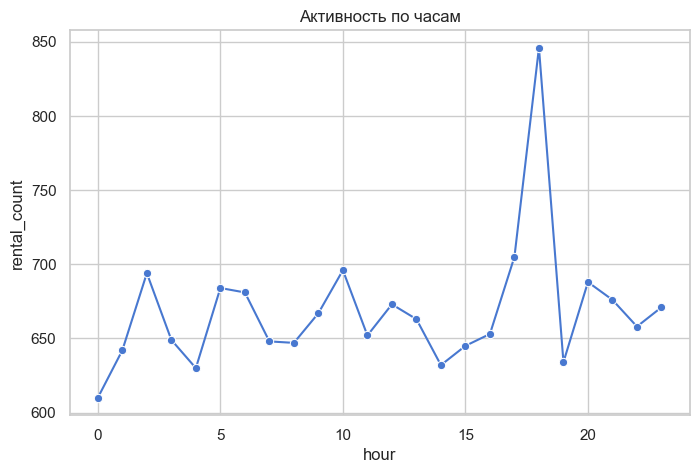

In [29]:
plot_heatmap(
    dfs['rental_activity_by_weekday_and_hour'],
    x="hour",
    y="weekday",
    value="rental_count",
    title="Активность по часам и дням недели"
)

plot_bar(
    dfs['rental_activity_by_weekday_and_hour']\
    .groupby("weekday", observed=True)["rental_count"].sum().reset_index(), 
    "weekday", 
    "rental_count", 
    "Активность по дням недели"
)

plot_line(
    dfs['rental_activity_by_weekday_and_hour']\
    .groupby("hour", observed=True)["rental_count"].sum().reset_index(),
    x="hour",
    y="rental_count",
    title="Активность по часам"
)

**Выводы**:
- На первом графике заметен выброс: в **понедельник** в **18 часов** был пик активности продаж, наименее активными являются *среда* и *четверг*;
- Наибольшее кол-во продаж приходится на **понедельник**;
- Что касается часовой активности, то ее пик (судя по третьему графику) приходится примерно на **18 часов**.

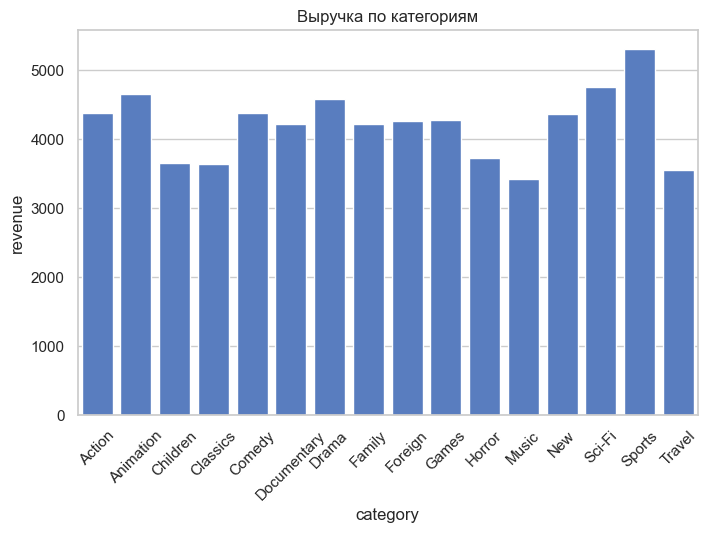

In [30]:
plot_bar(
    dfs['revenue_by_category'],
    x="category",
    y="revenue",
    title="Выручка по категориям",
    rotation=45
)

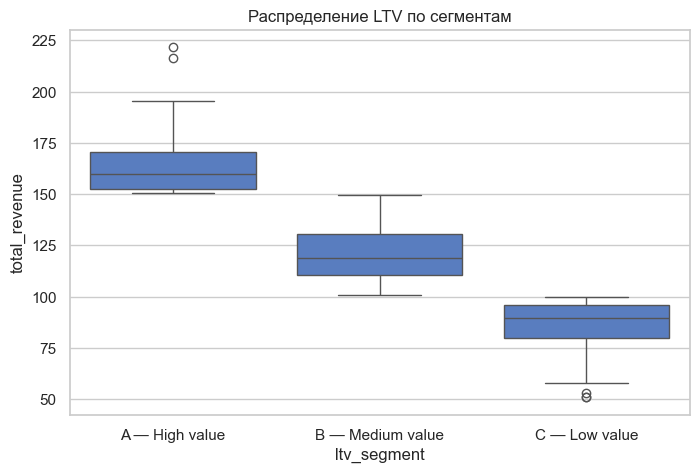

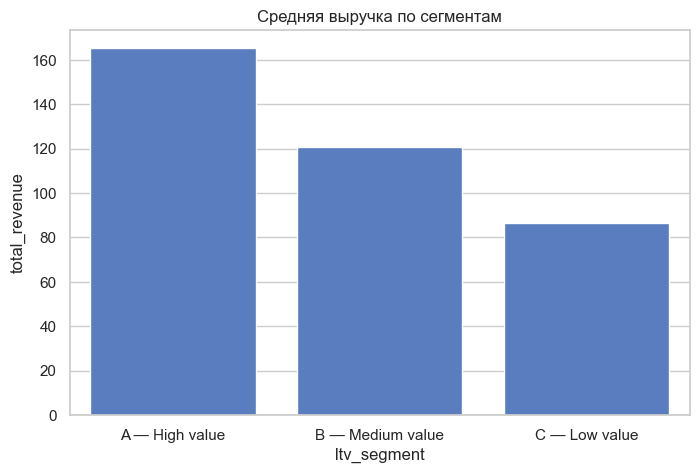

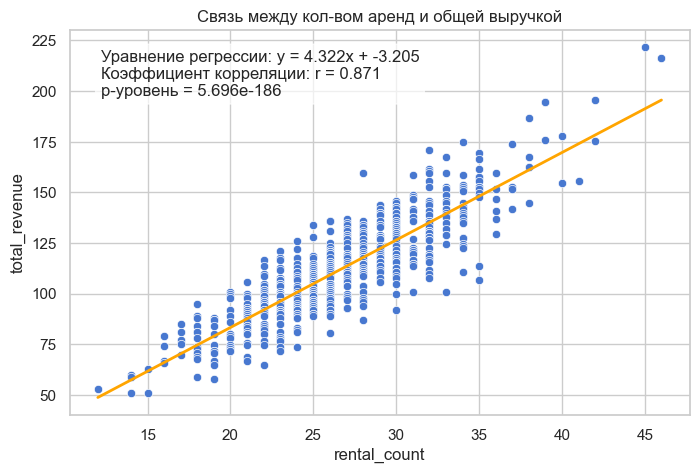

In [31]:
plot_box(
    dfs['customer_ltv'],
    x="ltv_segment",
    y="total_revenue",
    title="Распределение LTV по сегментам"
)

plot_bar(
    dfs['customer_ltv'].groupby('ltv_segment', observed=True)[['total_revenue']].mean().reset_index(),
    x="ltv_segment",
    y="total_revenue",
    title="Средняя выручка по сегментам"
)

plot_regression(
    dfs['customer_ltv'],
    x="rental_count",
    y="total_revenue",
    title="Связь между кол-вом аренд и общей выручкой"
)

**Выводы**:
- Средняя выручка больше для **High value**, далее идет *Medium value* и *Low value*;
- Клиенты сегмента **High value** совершают больше аренд и платят больше за транзакцию (по сравнению с *Medium*- и *Low* value);
- Корреляция между кол-вом продаж и общей выручкой **сильная** и **статистически значимая**.

### Проверка гипотез <a id="test"></a>

- #### *Гипотеза различия количества аренд для дней недели понедельник и среда*

**Нулевая гипотеза**: среднее количество аренд, совершенных в понедельник, *равно* среднему количеству аренд, совершенных в среду.

Уровень значимости зададим равный 0.05.

Сначала проверим данные на нормальное распределение, используя критерий *Шапиро-Уилка*:

In [32]:
def plot_with_shapiro(data, title, x_label, bins=15):
    stat, p_value = shapiro(data)

    plt.figure(figsize=(8, 5))
    sns.histplot(
        data,
        bins=bins,
        kde=True,
        stat='density',
        label=f'p-уровень: {p_value:.4f}'
    )
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('Плотность')
    plt.legend()
    plt.show()

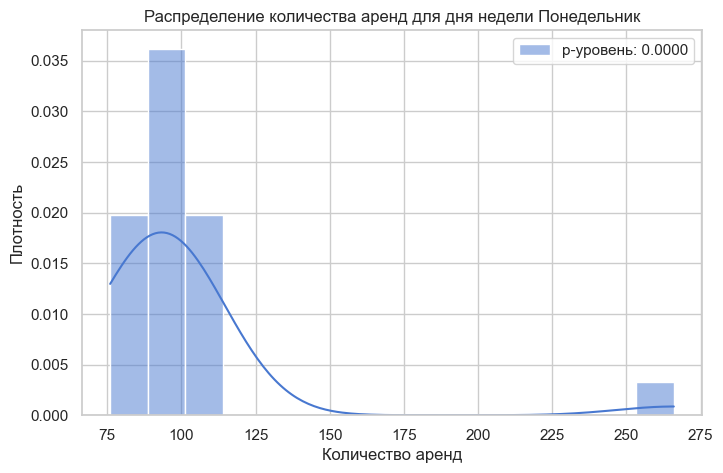

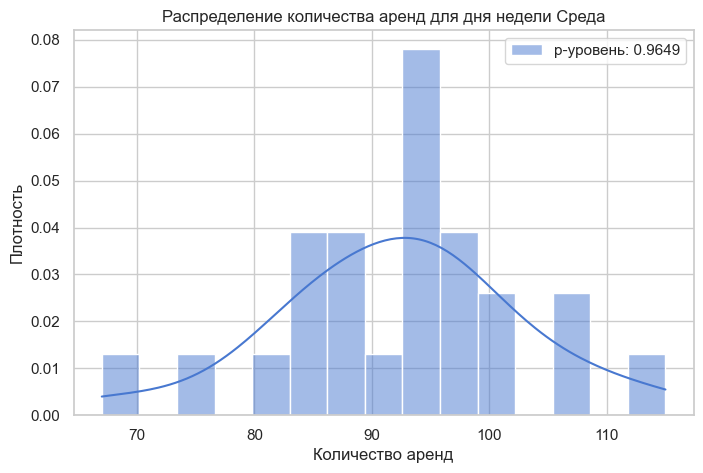

In [33]:
df = dfs["rental_activity_by_weekday_and_hour"]
plot_with_shapiro(
    df[df['weekday'] == 'Monday']['rental_count'],
    title='Распределение количества аренд для дня недели Понедельник',
    x_label = 'Количество аренд'
)

plot_with_shapiro(
    df[df['weekday'] == 'Wednesday']['rental_count'],
    title='Распределение количества аренд для дня недели Среда',
    x_label = 'Количество аренд'
)

Анализируя визуальное представление данных и полученные p-значения для двух выборок, делаем вывод о **нормальности распределения** *rental_count* для **среды** и **несоответствия закона распределения для понедельника** нормальному распределению.

В связи с этим будем применять для сравнения средних *непараметрический критерий Манна-Уитни*.

In [34]:
def mann_whitney_table(df, variable, *args):
    g1 = df[df[args[0]] == args[1]][variable].dropna()
    g2 = df[df[args[0]] == args[2]][variable].dropna()
    N1, N2 = len(g1), len(g2)
    all_values = np.concatenate([g1, g2])
    ranks = rankdata(all_values)
    rank_sum1 = ranks[:N1].sum()
    rank_sum2 = ranks[N1:].sum()
    
    U1, p = mannwhitneyu(g1, g2, alternative="two-sided")

    mu_U = N1 * N2 / 2
    sigma_U = np.sqrt(N1 * N2 * (N1 + N2 + 1) / 12)
    Z = (U1 - mu_U) / sigma_U

    table = pd.DataFrame({
        f"Сумма рангов ({args[1]})": [rank_sum1],
        f"Сумма рангов ({args[2]})": [rank_sum2],
        "U": [U1],
        "Z": [Z],
        "p-value": [p],
        f"N ({args[1]})": [N1],
        f"N ({args[2]})": [N2]
    })

    def highlight(val):
        if isinstance(val, float) and val < 0.05:
            return "color: red; font-weight: bold"
        return ""

    styled = table.style.map(highlight, subset=["p-value"])
    return styled

print("U критерий Манна-Уитни для кол-ва аренд:")
display(mann_whitney_table(df, 'rental_count', 'weekday', 'Monday', 'Wednesday'))

U критерий Манна-Уитни для кол-ва аренд:


,Сумма рангов (Monday),Сумма рангов (Wednesday),U,Z,p-value,N (Monday),N (Wednesday)
0,616.000000,560.000000,316.000000,0.577350,0.570048,24,24


p-значение критерия получилось равным *0.57* (> 0.05), то есть **нулевая гипотеза принимается**.

- #### *Гипотеза различия общей выручки клиентов сегментов High value и Medium value*

**Нулевая гипотеза**: средняя общая выручка клиентов сегмента High value *равна* средней общей выручки клиентов сегмента Medium value.

Сначала проверим данные на нормальное распределение, используя критерий *Шапиро-Уилка*:

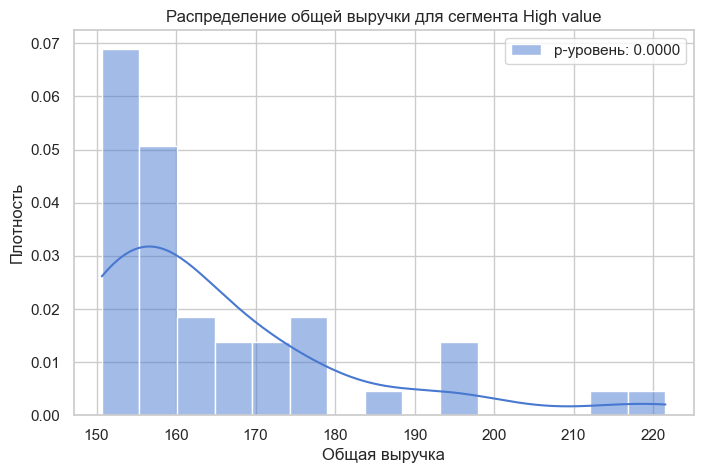

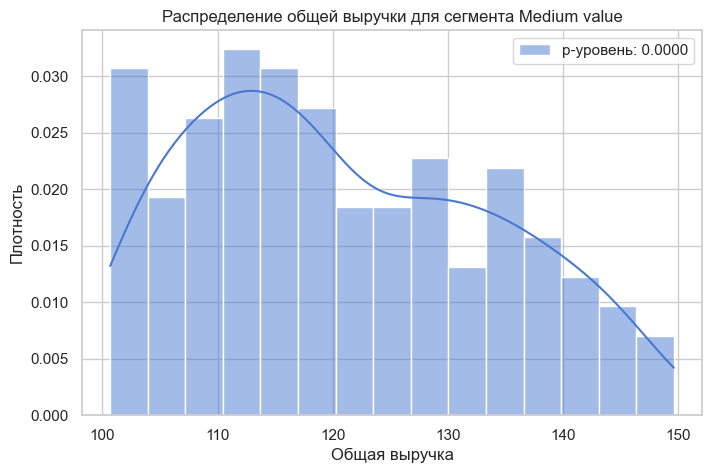

In [35]:
df = dfs["customer_ltv"]
plot_with_shapiro(
    df[df['ltv_segment'] == 'A — High value']['total_revenue'],
    title='Распределение общей выручки для сегмента High value',
    x_label = 'Общая выручка'
)

plot_with_shapiro(
    df[df['ltv_segment'] == 'B — Medium value']['total_revenue'],
    title='Распределение общей выручки для сегмента Medium value',
    x_label = 'Общая выручка'
)

Анализируя визуальное представление данных и полученные p-значения для двух выборок, делаем вывод о **несоответствии законов распределения** переменной total_revenue для *High value* и *Medium value* **нормальному**.

В связи с этим будем применять для сравнения средних *непараметрический критерий Манна-Уитни*.

In [36]:
print("U критерий Манна-Уитни для общей выручки:")
display(mann_whitney_table(df, 'total_revenue', 'ltv_segment', 'A — High value', 'B — Medium value'))

U критерий Манна-Уитни для общей выручки:


,Сумма рангов (A — High value),Сумма рангов (B — Medium value),U,Z,p-value,N (A — High value),N (B — Medium value)
0,17135.000000,61075.000000,16054.000000,11.028201,0.000000,46,349


p-значение критерия получилось равным 0.000000 (< 0.05), то есть **нулевая гипотеза отклоняется**.

## Итоги исследования

В ходе анализа были изучены четыре датасета сети видеопроката:

1. **`rental_activity_by_weekday_and_hour`** — количество аренд по дням недели и часам.
2. **`revenue_by_category`** — выручка по категориям фильмов.
3. **`revenue_by_genre_per_month`** — выручка по жанрам и по месяцам.
4. **`customer_ltv`** — информация о клиентах, их сегментах LTV и выручке.

Проведён **исследовательский анализ данных**, включающий:

- описательные статистики по основным метрикам;
- визуализацию распределений и динамики показателей.

Были проверены **две гипотезы** и установлено, что:

- среднее количество аренд в понедельник **статистически значимо не отличается** от среднего количества аренд в среду;
- средняя общая выручка клиентов сегмента High value **статистически значимо больше** выручки клиентов сегмента Medium value.